In [4]:
import pandas as pd 

In [5]:
df = pd.read_csv('../data/mental_health_processed.csv')

## NLP Data Cleaning

In [6]:
import string, nltk 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # 1. To lowercase
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    return ' '.join(tokens)

df['statement'] = df['statement'].apply(clean_text)

In [7]:
df.head()

,statement,sentiment
0,trouble sleep confuse mind restless heart tune,2
1,wrong back dear forward doubt stay restless re...,2
2,ive shift focus something else im still worried,2
3,im restless restless month boy mean,2
4,every break must nervous like something wrong ...,2


In [8]:
# Save cleaned data

df.to_csv('../data/mental_health_cleaned.csv', index=False)

In [33]:
from collections import Counter

# Tokenize statements
all_words = [word for text in df['statement'] for word in text.split()]
word_freq = Counter(all_words)

# Check vocabulary size
print(f"Vocabulary size: {len(word_freq)}")
print(word_freq.most_common(10))  # View top 10 most common words

Vocabulary size: 54317
[('feel', 29181), ('like', 24914), ('get', 23525), ('want', 22146), ('go', 20910), ('’', 19006), ('know', 16371), ('life', 14344), ('time', 12522), ('make', 12044)]


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1200)

X = tfidf.fit_transform(df['statement'])
y = df['sentiment']

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.769788062283737


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2983
           1       0.70      0.70      0.70      2560
           2       0.82      0.79      0.80      1802
           3       0.69      0.60      0.64      1903

    accuracy                           0.77      9248
   macro avg       0.76      0.75      0.76      9248
weighted avg       0.77      0.77      0.77      9248



<Axes: >

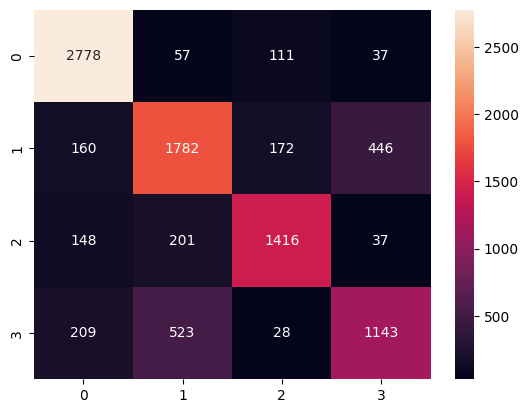

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [61]:
# Save model

import joblib

joblib.dump(model, '../out/mental_health_model.pkl')
joblib.dump(tfidf, '../out/mental_health_tfidf.pkl')

['../out/mental_health_tfidf.pkl']

In [16]:
# Test model

mapper = {
    0: 'Normal',
    1: 'Depression',
    2: 'Disorder',
    3: 'Suicidal'
}

def predict_sentiment(text):
    text = clean_text(text)
    text = tfidf.transform([text])
    return mapper[model.predict(text)[0]]

In [60]:
statements = [
    'How much does a polar bear weigh? Enough to break the ice! Hi, I am John.',

    'I am feeling anxious and nervous',

    'I can not sleep anymore I feel like I am going crazy',

    'I need help, I am feeling to end my life'
]


for statement in statements:
    sentiment = predict_sentiment(statement)
    print(f'Statement: {statement}')
    print(f'Sentiment: {sentiment}')
    print() 

Statement: How much does a polar bear weigh? Enough to break the ice! Hi, I am John.
Sentiment: Normal

Statement: I am feeling anxious and nervous
Sentiment: Disorder

Statement: I can not sleep anymore I feel like I am going crazy
Sentiment: Depression

Statement: I need help, I am feeling to end my life
Sentiment: Suicidal

